In [31]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import copy
from itertools import combinations

RUN_NAME = 'default' # don't forget to add corresponding folders for this.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#plt.style.use('dark_background')

def sample(model, epoch=-1, run_name='default'):
    plt.figure(figsize=[12,5])

    for i, (real, fake, real_test, test) in enumerate(zip(
                                            x_train[:10], 
                                            model(x_train[:10].to(device)),
                                            x_test[:10], 
                                            model(x_test[:10].to(device)))):

        plt.subplot(4,10,i+1)
        plt.imshow(real.detach().numpy().squeeze(), cmap='inferno')
        plt.axis('off')

        plt.subplot(4,10,i+11)
        plt.imshow(fake.detach().cpu().numpy().squeeze(), cmap='inferno')
        plt.axis('off')
        
        plt.subplot(4,10,i+21)
        plt.imshow(real_test.detach().cpu().numpy().squeeze(), cmap='inferno')
        plt.axis('off')
        
        plt.subplot(4,10,i+31)
        plt.imshow(test.detach().cpu().numpy().squeeze(), cmap='inferno')
        plt.axis('off')
    
    # plt.savefig(f'./training_images/{run_name}/epoch_{epoch}.png', 
    #             bbox_inches='tight')
    plt.show()
    
    
# Model:

class ConvAutoencoder(nn.Module):
    
    def __init__(self, n_latent=3):
        super(ConvAutoencoder, self).__init__()

        # Encoder 
        self.enc = nn.Sequential(
            nn.Conv2d(1, 128, 3, stride=2, padding=1, bias=True), 
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, stride=2, padding=1, bias=True), 
            nn.ReLU(),
            nn.Conv2d(64, 16, 3, stride=2, padding=1, bias=True), 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 64, bias=True), 
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            # nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, n_latent))
        
        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(n_latent, 32, bias=True), 
            nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            # nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, 256, bias=True),
            nn.ReLU(), 
            nn.Unflatten(1, (16,4,4)),
            nn.ConvTranspose2d(16, 64, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def forward(self, x): 
        
        return self.dec(self.enc(x))


    
auto = ConvAutoencoder(2)

auto.load_state_dict(torch.load('auto_2latent_binary.pth'))
    
    
# Load Data:

mnist_dataset = MNIST(root='', train=True, 
                      transform=transforms.ToTensor(), download=False)

class MyDataset(Dataset):
    
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

max_num = 1
x = mnist_dataset.data[mnist_dataset.targets <= max_num][:,None,:,:].float()/255
y = mnist_dataset.targets[mnist_dataset.targets <= max_num][:,None].float()

with torch.no_grad():
    z = auto.enc(x)

np.random.seed(0)
torch.manual_seed(0)
    
z_train, z_test, y_train, y_test = train_test_split(z, y, test_size=.25, shuffle=True)

train_dataset = MyDataset(z_train, y_train)
test_dataset  = MyDataset(z_test,  y_test)

# Hyperparameters
num_epochs = 100
batch_size = 256
learning_rate = 1e-4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [32]:
# Model:

class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()

        # Encoder 
        self.layers = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            # nn.Linear(32, 10),
            nn.Linear(32, 1)
        )

    def forward(self, x): 
        
        # F.softmax(self.layers(x), 1)
        
        return torch.sigmoid(self.layers(x))

In [33]:
model = Classifier()
model.to(device)

Classifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [34]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = np.zeros((num_epochs, 2))

# Train the model
for epoch in range(num_epochs):
    
    train_loss = 0
    for z_batch, y_batch in train_dataloader:
        
        loss = criterion(model(z_batch.to(device)), y_batch.to(device))
        train_loss += loss.item()*z_batch.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    test_loss = 0
    for z_batch, y_batch in test_dataloader:
        
        loss = criterion(model(z_batch.to(device)), y_batch.to(device))
        test_loss += loss.item()*z_batch.shape[0]
        
    loss_history[epoch, 0] = train_loss / train_dataloader.dataset.x.shape[0]
    loss_history[epoch, 1] = test_loss / test_dataloader.dataset.x.shape[0]
        
    # if epoch % 50 == 0:
    #     sample(model, epoch, RUN_NAME)
    
    # torch.save(model.state_dict(), 
    #            f'./trained_models/{RUN_NAME}/conv_model_weights_test.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_history[epoch,0]:.4f}, Val Loss: {loss_history[epoch,1]:.4f}",end='\r')

In [35]:
model.to('cpu')

y_pred = model.layers(z_test).flatten().detach().numpy()

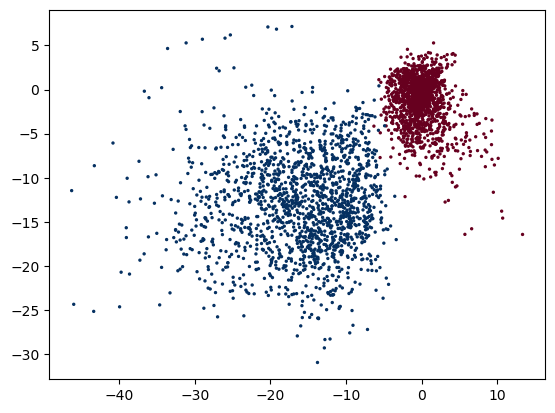

In [36]:
plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=2, cmap='RdBu')

In [37]:
X, Y = np.meshgrid(np.linspace(-40,20,100), np.linspace(-30,10,100))
grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()]).T).float()

grid_preds = model.layers(grid_points).flatten().detach().numpy()

In [38]:
def inv_sigmoid(x):
    return -np.log(np.maximum((1 / np.maximum(x, 1e-30)) - 1, .0001))

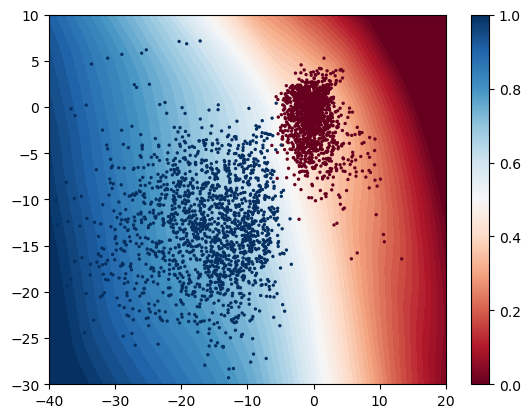

In [39]:
plt.contourf(X, Y, grid_preds.reshape((100,100)), 100, cmap='RdBu', vmin=-40, vmax=40)
plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=2, cmap='RdBu')
plt.axis([-40,20,-30,10])
plt.colorbar()

In [40]:
def normalized_dot(a,b):
    '''Given a_ij, b_ik returns a_ij b_ij / (|a_i|*|b_i|) (summed only over j!)
    This is equivalent to einsum('ik,jk', a, b).diag(), but avoids needlessly 
    computing the off diagonal elements. '''
    
    return torch.sum(a * b, dim=1) / (torch.norm(a, dim=1) * torch.norm(b, dim=1) + 1e-16)

def make_orthonormal(vecs):
    
    new_vecs = []

    def normalize(v):
        return v / torch.norm(v)

    for i, v in enumerate(vecs):

        #in_space_comp = torch.zeros((i, v.shape[0]))
        projections = [torch.zeros_like(v)]

        for j, w in enumerate(new_vecs[:i]):
            projections.append(v @ w * w)

        new_vecs.append(normalize(v - torch.stack(projections).sum(dim=0)))

    return torch.stack(new_vecs)


def get_nullspace_component(vec, basis):
    
    in_subspace_component = []
    
    for i, b in enumerate(basis):
        in_subspace_component.append(b * torch.dot(vec, b))
        
    return torch.norm(vec - torch.sum(torch.stack(in_subspace_component), dim=0))


def closure_loss(params):
    
    generators = [p for p in params]
    
    vecs = torch.flatten(torch.stack(generators), start_dim=1)
    basis = make_orthonormal(vecs)
    
    temp = [torch.tensor(0)]
    
    for i,j in combinations(range(len(generators)), 2):
        
        brac = bracket(generators[i], generators[j]).flatten()
        temp.append(get_nullspace_component(brac, basis)**2)
    
    return torch.sum(torch.stack(temp))


def ensemble_loss(inp, 
                  model, 
                  h_inv=1,
                  h_norm=1,
                  h_orth=0,
                  h_clos=0,
                  eps=1e-3,
                  return_components=False):

    transformed = model(inp, eps)
    
    loss_inv  = 0
    loss_norm = 0
    loss_orth = 0
    
    for x_tran in transformed:
        
        loss_inv  += torch.mean((oracle(inp) - oracle(x_tran))**2) / eps**2
        
        loss_norm += (torch.norm(x_tran - inp, dim=1).mean()/eps - 1)**2
        loss_norm += torch.norm(x_tran - inp, dim=1).std()/eps
    
    # Data-driven orthogonality loss
    for i,j in combinations(range(len(transformed)),2):
        
        loss_orth += torch.mean(normalized_dot(transformed[i]-inp, transformed[j]-inp)**2)

    loss_clos = 0 #closure_loss(model.parameters())
    
    # We have this option for debugging: 
    # If the loss isn't converging, this allows us to see which term is responsible
    if return_components:
        return (float(h_inv  * loss_inv ), 
                float(h_norm * loss_norm), 
                float(h_orth * loss_orth),
                float(h_clos * loss_clos))
     
    return (  h_inv  * loss_inv 
            + h_norm * loss_norm 
            + h_orth * loss_orth
            + h_clos * loss_clos)

In [41]:
class GeneratorModel(nn.Module):
    
    def __init__(self, n_dim=3, n_latent=16, n_generators=1):
        super(GeneratorModel, self).__init__()
        
        self.n_generators = n_generators
        
        W_list = [nn.Sequential(nn.Linear(n_dim, n_latent), nn.ReLU(),
                                # nn.Linear(n_latent, n_latent), nn.ReLU(),
                                nn.Linear(n_latent, n_dim))
                                #nn.Sigmoid(),
                                #nn.Linear(n_latent, n_dim)
                            for _ in range(n_generators)]
        
#         W_list = [nn.Sequential(nn.Linear(n_dim, n_latent),
#                                 nn.ReLU(),
#                                 nn.Linear(n_latent, n_dim))
#                   for _ in range(n_generators)]
        
        self.W_list = nn.ModuleList(W_list)
        
    def forward(self, inp, epsilon=1e-3):
        
        outputs = []
        for i in range(self.n_generators):
            outputs.append(inp + epsilon * self.W_list[i](inp))
        
        return outputs

In [42]:
model = model.to('cpu')

def oracle(x):
    return model.layers(x)

epoch 800: Loss: 0.08450707793235779                     
 Best Loss: 0.08450707793235779 



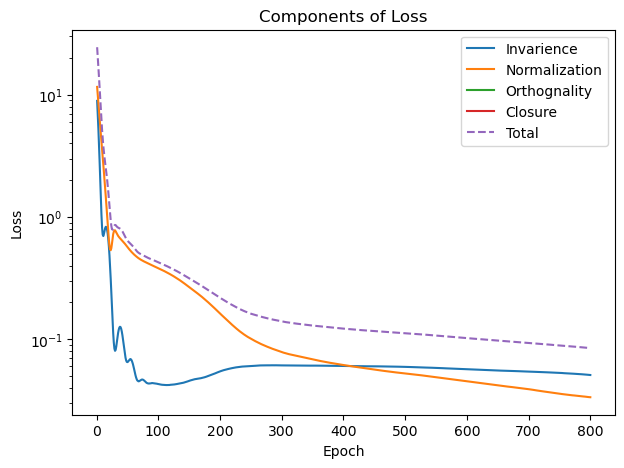

In [43]:
dataset = z_train.to('cpu')

y = oracle(dataset)

np.random.seed(0)
torch.manual_seed(0)
generator = GeneratorModel(n_dim=2, n_latent=32).to('cpu')

# At this point you can use `model(dataset)` to get the transformed datasets.
# Though at this point the generators are just these random matricies:

# visualize_generators(model.parameters(), n_generators=n_generators)

# Hyperparameters
lr = .002
n_epochs = 800
eps = 1e-4

h_inv  = 1
h_norm = 1
h_orth = 1
h_clos = 1

# Define the optimizer
optim = torch.optim.Adam(generator.parameters(), lr=lr)

# Keep track of some things
best_loss_so_far = np.inf
loss_history = []
loss_components = []

for epoch in range(1, n_epochs+1):

    # Gradient descent part:
    optim.zero_grad()

    loss = ensemble_loss(dataset, 
                         generator, 
                         h_inv=h_inv,
                         h_norm=h_norm,
                         h_orth=h_orth,
                         h_clos=h_clos,
                         eps=eps)
    loss.backward()
    optim.step()

    # Show and track progress:
    if epoch % 1 == 0:

        print(f'epoch {epoch}: Loss: {float(loss)}', ' '*20, end='\r')
        loss_history.append((epoch, float(loss)))
        loss_components.append((epoch, 
                                *ensemble_loss(dataset, generator,
                                               h_inv=h_inv,
                                               h_norm=h_norm,
                                               h_orth=h_orth,
                                               h_clos=h_clos,
                                               eps=eps,
                                               return_components=True)))

    # Keep track of best model so far:
    if loss < best_loss_so_far:
        best_loss_so_far = loss
        best_model       = copy.deepcopy(generator)
        best_model_epoch = epoch

        # # break training if loss gets really small
        # if loss < stopping_thresh:
        #     print(f'epoch {epoch}: Loss: {float(loss)}', ' '*20)
        #     print('Reached loss near machine zero')
        #     loss_history.append((epoch, float(loss)))
        #     break

else: print('\n', f'Best Loss: {best_loss_so_far} \n')

# ### Visualize the loss during the training process:

# I have broken the loss into the three parts:
#  - Invarience: (controlled by `h_inv`)
#  - Normalization: (controlled by `h_norm`)
#  - Closure: (controlled by `h_orth`)

loss_history = np.array(loss_history)
loss_components = np.array(loss_components)

plt.figure(figsize=[7,5], dpi=100)

plt.plot(loss_components[:,0], loss_components[:,1], label='Invarience')
plt.plot(loss_components[:,0], loss_components[:,2], label='Normalization')
plt.plot(loss_components[:,0], loss_components[:,3], label='Orthognality')
plt.plot(loss_components[:,0], loss_components[:,4], label='Closure')
plt.plot(loss_history[:,0], loss_history[:,1], ls='--', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

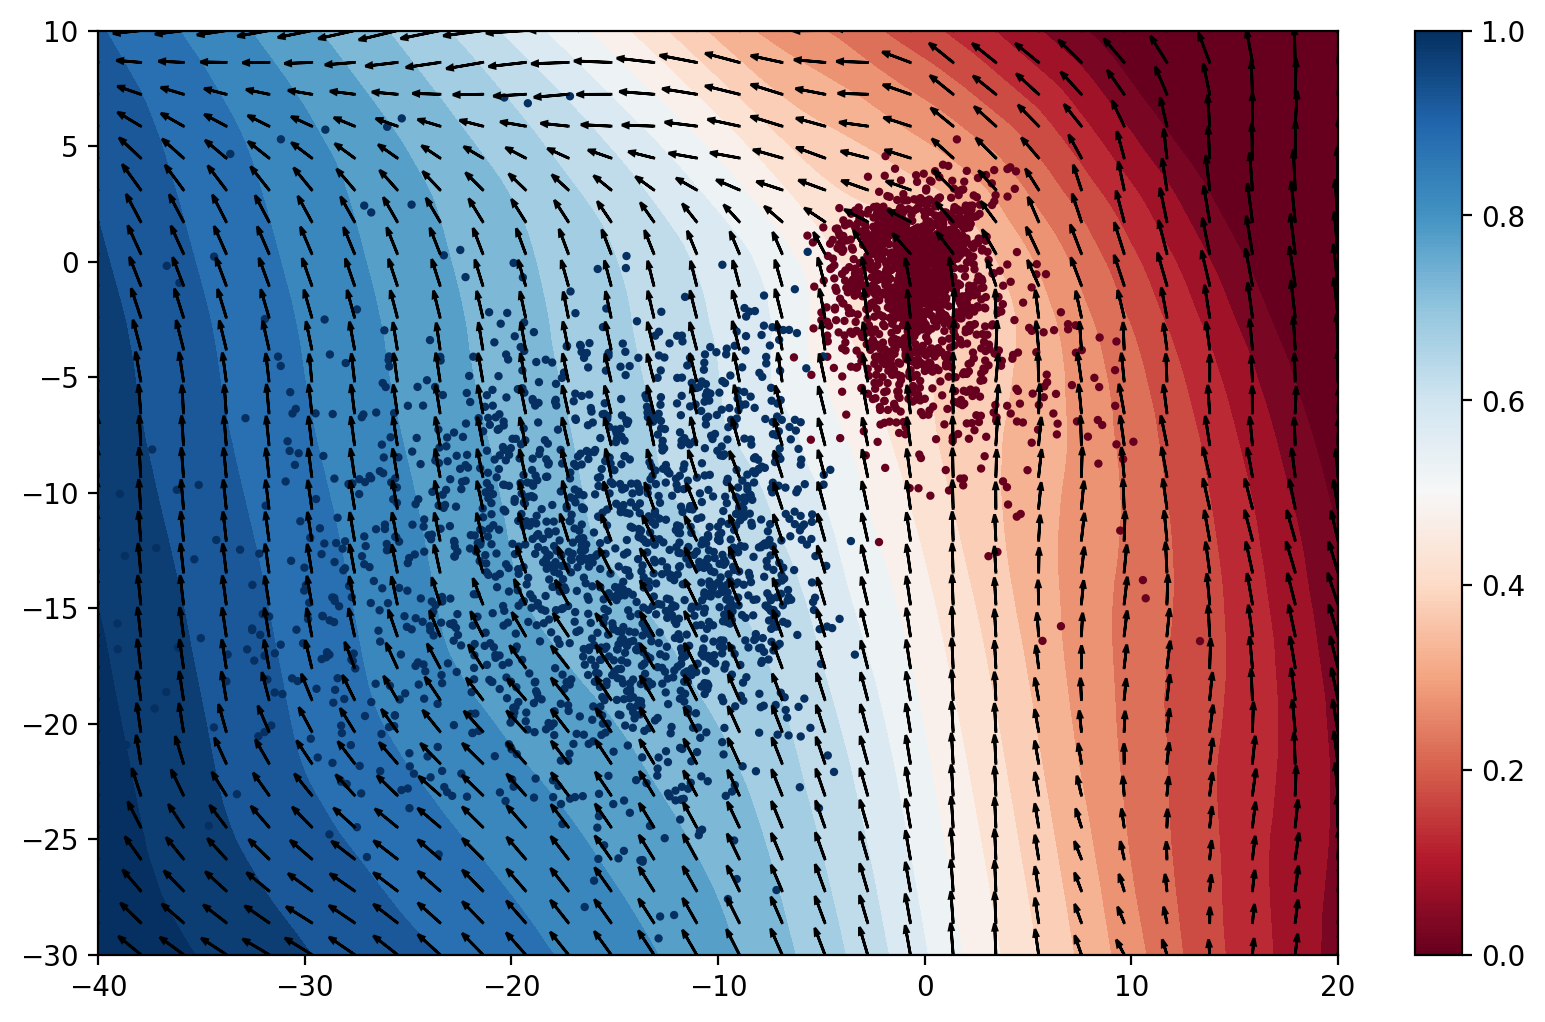

In [48]:
X_vec, Y_vec = np.meshgrid(np.linspace(-40,20,30), np.linspace(-30,10,30))
vec_grid_points = torch.tensor(np.stack([X_vec.flatten(), Y_vec.flatten()]).T).float()

vec_grid = generator.W_list[0](vec_grid_points).detach().numpy()

plt.figure(figsize=[10,6], dpi=200)
plt.contourf(X, Y, grid_preds.reshape((100,100)), 30, cmap='RdBu', vmin=-40, vmax=40)
plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=4, cmap='RdBu', alpha=1)
plt.axis([-40,20,-30,10])
for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), head_width=.2, color='k')
plt.colorbar()

In [49]:
inds = np.all([-7 < z_test.numpy()[:,0], z_test.numpy()[:,0] < -5, 
               -18 < z_test.numpy()[:,1], z_test.numpy()[:,1] < -16], axis=0)

np.where(inds)[0]

array([364, 733])

In [50]:
inds = np.all([2 < z_test.numpy()[:,0], z_test.numpy()[:,0] < 5, 
               -11 < z_test.numpy()[:,1], z_test.numpy()[:,1] < -9], axis=0)

np.where(inds)[0][0]

1172

In [51]:
z_test[1170]

tensor([-2.0630,  0.4316])

In [52]:
# my_z = torch.tensor([ -6.7115, -16.4715]) #z_test[360]
my_z = torch.tensor([ -6.7115, -18]) #z_test[360]

path_history1 = [my_z.numpy()]

for i in range(1,25000):
    my_z = generator(my_z)[0].detach()
    
    if i%100==0:
        path_history1.append(my_z.numpy())
    
path_history1 = np.array(path_history1)

In [53]:
# my_z = torch.tensor([ 2.8928, -9.9429]) - torch.tensor([0,5]).float()
my_z = torch.tensor([ 2.8928, -18])

path_history2 = [my_z.numpy()]

for i in range(1,25000):
    my_z = generator(my_z)[0].detach()
    
    if i%100==0:
        path_history2.append(my_z.numpy())
    
path_history2 = np.array(path_history2)

In [54]:
my_z = torch.tensor([-.3,-18]).float()

path_history3 = [my_z.numpy()]

for i in range(1,25000):
    my_z = generator(my_z)[0].detach()
    
    if i%100==0:
        path_history3.append(my_z.numpy())
    
path_history3 = np.array(path_history3)

In [55]:
platonic_0 = z_test[y_test.flatten()==0].mean(0)
platonic_1 = z_test[y_test.flatten()==1].mean(0)
frac = torch.tensor(np.linspace(0,1,101))
z_platonic_interp = frac[:,None] * platonic_1 + (1-frac[:,None]) * platonic_0

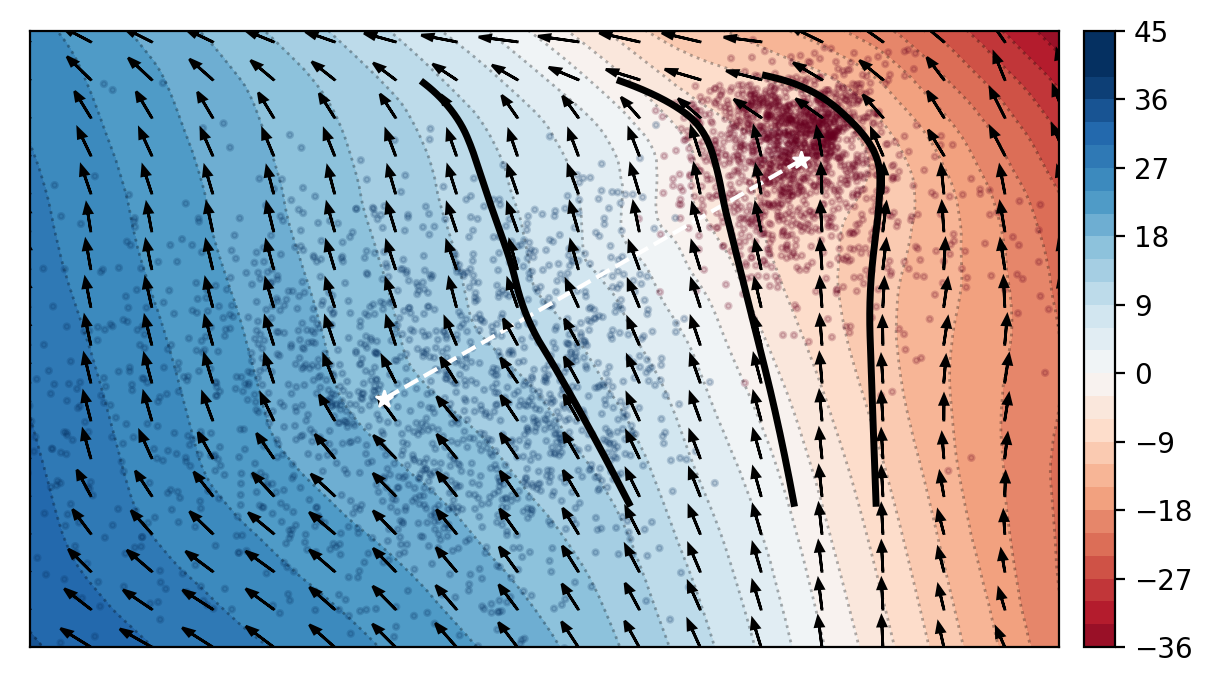

In [56]:
plt.style.use('default')

X_vec, Y_vec = np.meshgrid(np.linspace(-30,15,20), np.linspace(-25,10,20))
vec_grid_points = torch.tensor(np.stack([X_vec.flatten(), Y_vec.flatten()]).T).float()

vec_grid = generator.W_list[0](vec_grid_points).detach().numpy()

plt.figure(figsize=[8,4], dpi=200)
plt.contourf(X, Y, np.maximum(-36,grid_preds.reshape((100,100))), 30, cmap='RdBu', vmin=-40, vmax=40, zorder=-20)
plt.colorbar(pad=.02)
plt.contour(X, Y, np.maximum(-36,grid_preds.reshape((100,100))), 30, cmap='gray', vmin=0, vmax=10000, 
            linewidths=1, linestyles='dotted', zorder=-10, alpha=.3)

plt.scatter(*platonic_0, color='w', marker='*', zorder=5)
plt.scatter(*platonic_1, color='w', marker='*', zorder=5)
plt.plot([platonic_0[0], platonic_1[0]], [platonic_0[1], platonic_1[1]], ls='--', color='w')

plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=4, cmap='RdBu', alpha=.2)
# plt.scatter(*z_test[658].detach().numpy(), c='yellow', s=100, marker='*', cmap='RdBu', alpha=1)
plt.plot(*path_history1.T, lw=2.5, c='k')
plt.plot(*path_history2.T, lw=2.5, c='k')
plt.plot(*path_history3.T, lw=2.5, c='k')
plt.axis([-30,10,-25,5])
plt.xticks([])
plt.yticks([])
for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), lw=1, head_width=.3, color='k', zorder=3)
    
# plt.savefig('binary_2d_latent_vector_plot.png', bbox_inches='tight')

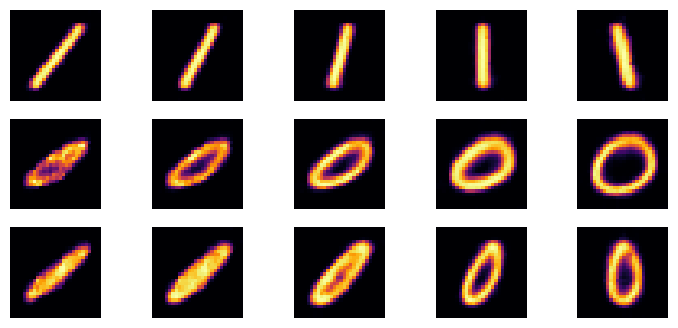

In [57]:
plt.figure(figsize=[18,4])

ll = 10

for i, im in enumerate(auto.dec(torch.tensor(path_history1[::50]))):
    plt.subplot(3,ll,i+1)
    plt.imshow(im.detach().numpy().squeeze(), cmap='inferno')
    plt.axis('off')
    
for i, im in enumerate(auto.dec(torch.tensor(path_history2[::50]))):
    plt.subplot(3,ll,ll+i+1)
    plt.imshow(im.detach().numpy().squeeze(), cmap='inferno')
    plt.axis('off')
    
for i, im in enumerate(auto.dec(torch.tensor(path_history3[::50]))):
    plt.subplot(3,ll,2*ll+i+1)
    plt.imshow(im.detach().numpy().squeeze(), cmap='inferno')
    plt.axis('off')

In [58]:
ims_platonic_interp = auto.dec(z_platonic_interp.float())[::10].detach().numpy().squeeze()

In [59]:
ps_platonic_interp = model(z_platonic_interp.float()).detach().numpy().flatten()

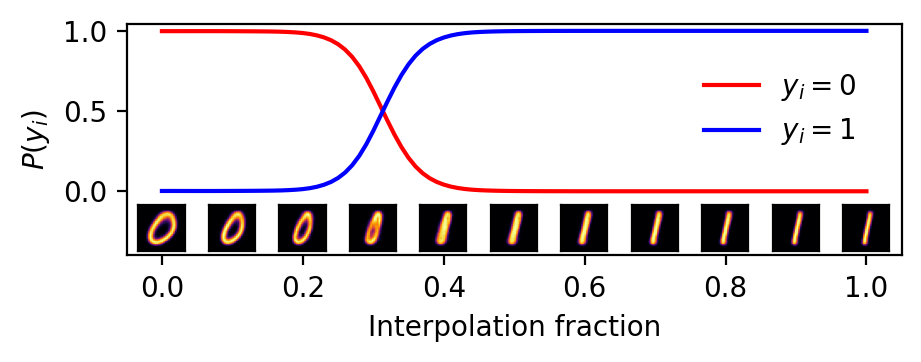

In [60]:
fig, ax = plt.subplots(1,1, figsize=[5,1.5], dpi=200)

ax.plot(frac, 1-ps_platonic_interp, label='$y_i=0$',c='r')
ax.plot(frac, ps_platonic_interp, label='$y_i=1$',c='b')
ax.set_ylabel('$P(y_i)$')
ax.set_xlabel('Interpolation fraction')
ax.legend(loc=[.73,.42], frameon=False)
ax.set_ylim(-.4,1.04)

for i, im in enumerate(ims_platonic_interp):
    ins = ax.inset_axes([i/11-.055,0.02,0.2,0.2])
    ins.imshow(im, cmap='inferno')
    ins.set_xticks([])
    ins.set_yticks([])
    
plt.savefig('binary_2d_platonic_iterpolation.png', bbox_inches='tight')

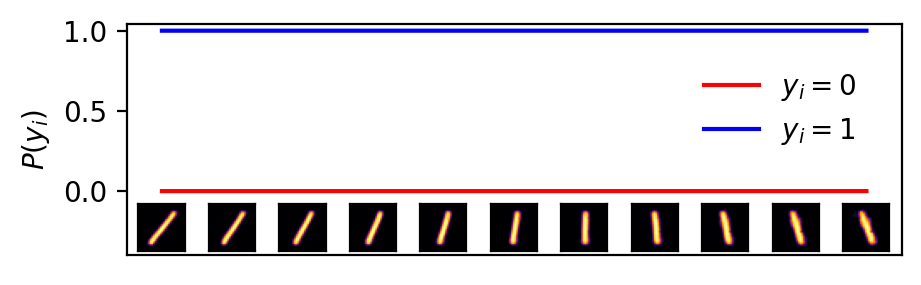

In [61]:
ims = auto.dec(torch.tensor(path_history1[::24])).detach().numpy().squeeze()
ps = model(torch.tensor(path_history1)).detach().numpy().squeeze()

fig, ax = plt.subplots(1,1, figsize=[5,1.5], dpi=200)

ax.plot(1-ps, label='$y_i=0$',c='r')
ax.plot(ps, label='$y_i=1$',c='b')
ax.set_ylabel('$P(y_i)$')
#ax.set_xlabel('Interpolation fraction')
ax.set_xticks([])
ax.legend(loc=[.73,.42], frameon=False)
ax.set_ylim(-.4,1.04)

for i, im in enumerate(ims):
    ins = ax.inset_axes([i/11-.055,0.02,0.2,0.2])
    ins.imshow(im, cmap='inferno')
    ins.set_xticks([])
    ins.set_yticks([])
    
plt.savefig('binary_2d_morph_one.png', bbox_inches='tight')

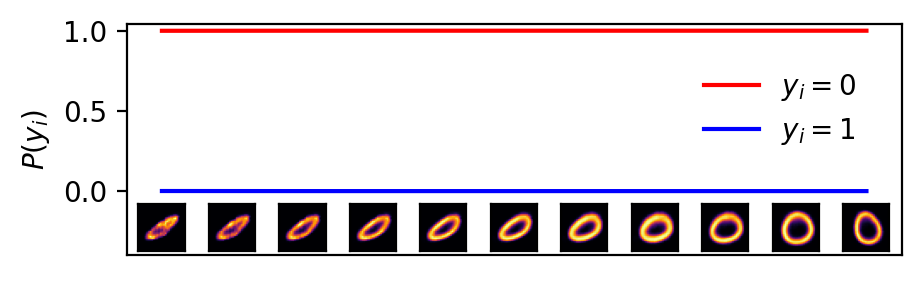

In [62]:
ims = auto.dec(torch.tensor(path_history2[::24])).detach().numpy().squeeze()
ps = model(torch.tensor(path_history2)).detach().numpy().squeeze()

fig, ax = plt.subplots(1,1, figsize=[5,1.5], dpi=200)

ax.plot(1-ps, label='$y_i=0$',c='r')
ax.plot(ps, label='$y_i=1$',c='b')
ax.set_ylabel('$P(y_i)$')
#ax.set_xlabel('Interpolation fraction')
ax.set_xticks([])
ax.legend(loc=[.73,.42], frameon=False)
ax.set_ylim(-.4,1.04)

for i, im in enumerate(ims):
    ins = ax.inset_axes([i/11-.055,0.02,0.2,0.2])
    ins.imshow(im, cmap='inferno')
    ins.set_xticks([])
    ins.set_yticks([])
    
plt.savefig('binary_2d_morph_zero.png', bbox_inches='tight')

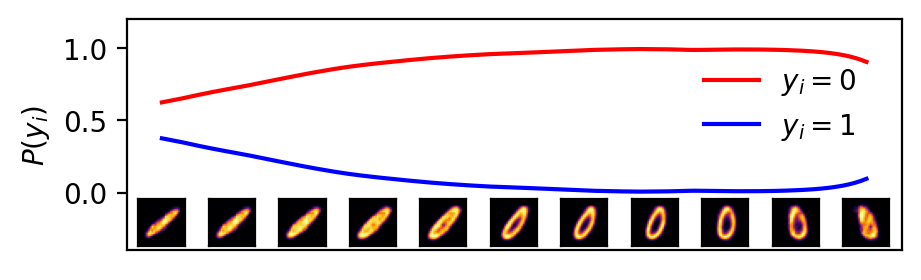

In [73]:
ims = auto.dec(torch.tensor(path_history3[::24])).detach().numpy().squeeze()
ps = model(torch.tensor(path_history3)).detach().numpy().squeeze()

fig, ax = plt.subplots(1,1, figsize=[5,1.5], dpi=200)

ax.plot(1-ps, label='$y_i=0$',c='r')
ax.plot(ps, label='$y_i=1$',c='b')
ax.set_ylabel('$P(y_i)$')
#ax.set_xlabel('Interpolation fraction')
ax.set_xticks([])
ax.legend(loc=[.73,.42], frameon=False, ncol=1)
ax.set_ylim(-.4,1.2)

for i, im in enumerate(ims):
    ins = ax.inset_axes([i/11-.055,0.02,0.2,0.2])
    ins.imshow(im, cmap='inferno')
    ins.set_xticks([])
    ins.set_yticks([])
    
plt.savefig('binary_2d_morph_half.png', bbox_inches='tight')

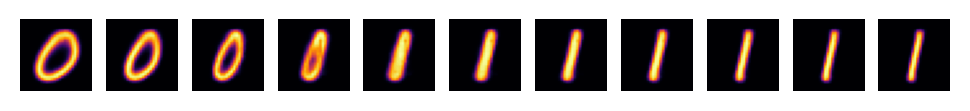

In [64]:
plt.figure(figsize=(6,1), dpi=200)

for i, (im, p) in enumerate(zip(ims_platonic_interp, ps_platonic_interp)):
    plt.subplot(1,11,i+1)
    plt.imshow(im, cmap='inferno')
    plt.axis('off')

In [65]:
model.layers(torch.tensor(path_history3[::50]))

tensor([[-0.5089],
        [-1.5027],
        [-2.7337],
        [-4.2858],
        [-4.6629]], grad_fn=<AddmmBackward0>)

### Training with two generators

epoch 3000: Loss: 0.6794082522392273                     
 Best Loss: 0.6794082522392273 



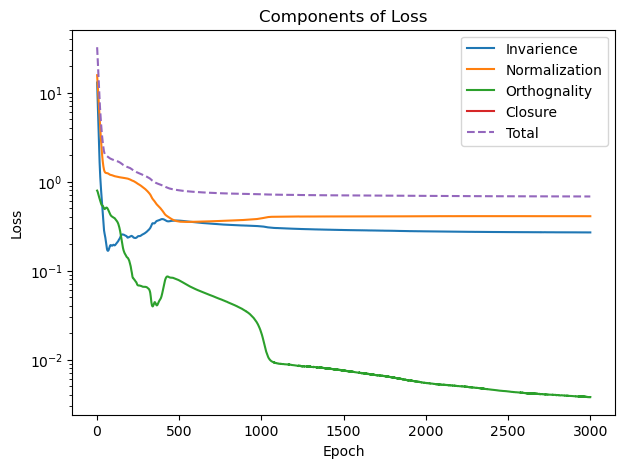

In [66]:
dataset = z_train

y = oracle(dataset)

np.random.seed(0)
torch.manual_seed(0)
generator2 = GeneratorModel(n_dim=2, n_latent=32, n_generators=2)

# At this point you can use `model(dataset)` to get the transformed datasets.
# Though at this point the generators are just these random matricies:

# visualize_generators(model.parameters(), n_generators=n_generators)

# Hyperparameters
lr = .001
n_epochs = 3000
eps = 1e-4

h_inv  = 1
h_norm = 1
h_orth = 1
h_clos = 1

# Define the optimizer
optim = torch.optim.Adam(generator2.parameters(), lr=lr)

# Keep track of some things
best_loss_so_far = np.inf
loss_history = []
loss_components = []

for epoch in range(1, n_epochs+1):

    # Gradient descent part:
    optim.zero_grad()

    loss = ensemble_loss(dataset, 
                         generator2, 
                         h_inv=h_inv,
                         h_norm=h_norm,
                         h_orth=h_orth,
                         h_clos=h_clos,
                         eps=eps)
    if torch.isnan(loss):
        break
    
    loss.backward()
    optim.step()

    # Show and track progress:
    if epoch % 1 == 0:

        print(f'epoch {epoch}: Loss: {float(loss)}', ' '*20, end='\r')
        loss_history.append((epoch, float(loss)))
        loss_components.append((epoch, 
                                *ensemble_loss(dataset, generator2,
                                               h_inv=h_inv,
                                               h_norm=h_norm,
                                               h_orth=h_orth,
                                               h_clos=h_clos,
                                               eps=eps,
                                               return_components=True)))

    # Keep track of best model so far:
    if loss < best_loss_so_far:
        best_loss_so_far = loss
        best_model2       = copy.deepcopy(generator2)
        best_model_epoch = epoch

        # # break training if loss gets really small
        # if loss < stopping_thresh:
        #     print(f'epoch {epoch}: Loss: {float(loss)}', ' '*20)
        #     print('Reached loss near machine zero')
        #     loss_history.append((epoch, float(loss)))
        #     break

else: print('\n', f'Best Loss: {best_loss_so_far} \n')

# ### Visualize the loss during the training process:

# I have broken the loss into the three parts:
#  - Invarience: (controlled by `h_inv`)
#  - Normalization: (controlled by `h_norm`)
#  - Closure: (controlled by `h_orth`)

loss_history = np.array(loss_history)
loss_components = np.array(loss_components)

plt.figure(figsize=[7,5], dpi=100)

plt.plot(loss_components[:,0], loss_components[:,1], label='Invarience')
plt.plot(loss_components[:,0], loss_components[:,2], label='Normalization')
plt.plot(loss_components[:,0], loss_components[:,3], label='Orthognality')
plt.plot(loss_components[:,0], loss_components[:,4], label='Closure')
plt.plot(loss_history[:,0], loss_history[:,1], ls='--', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

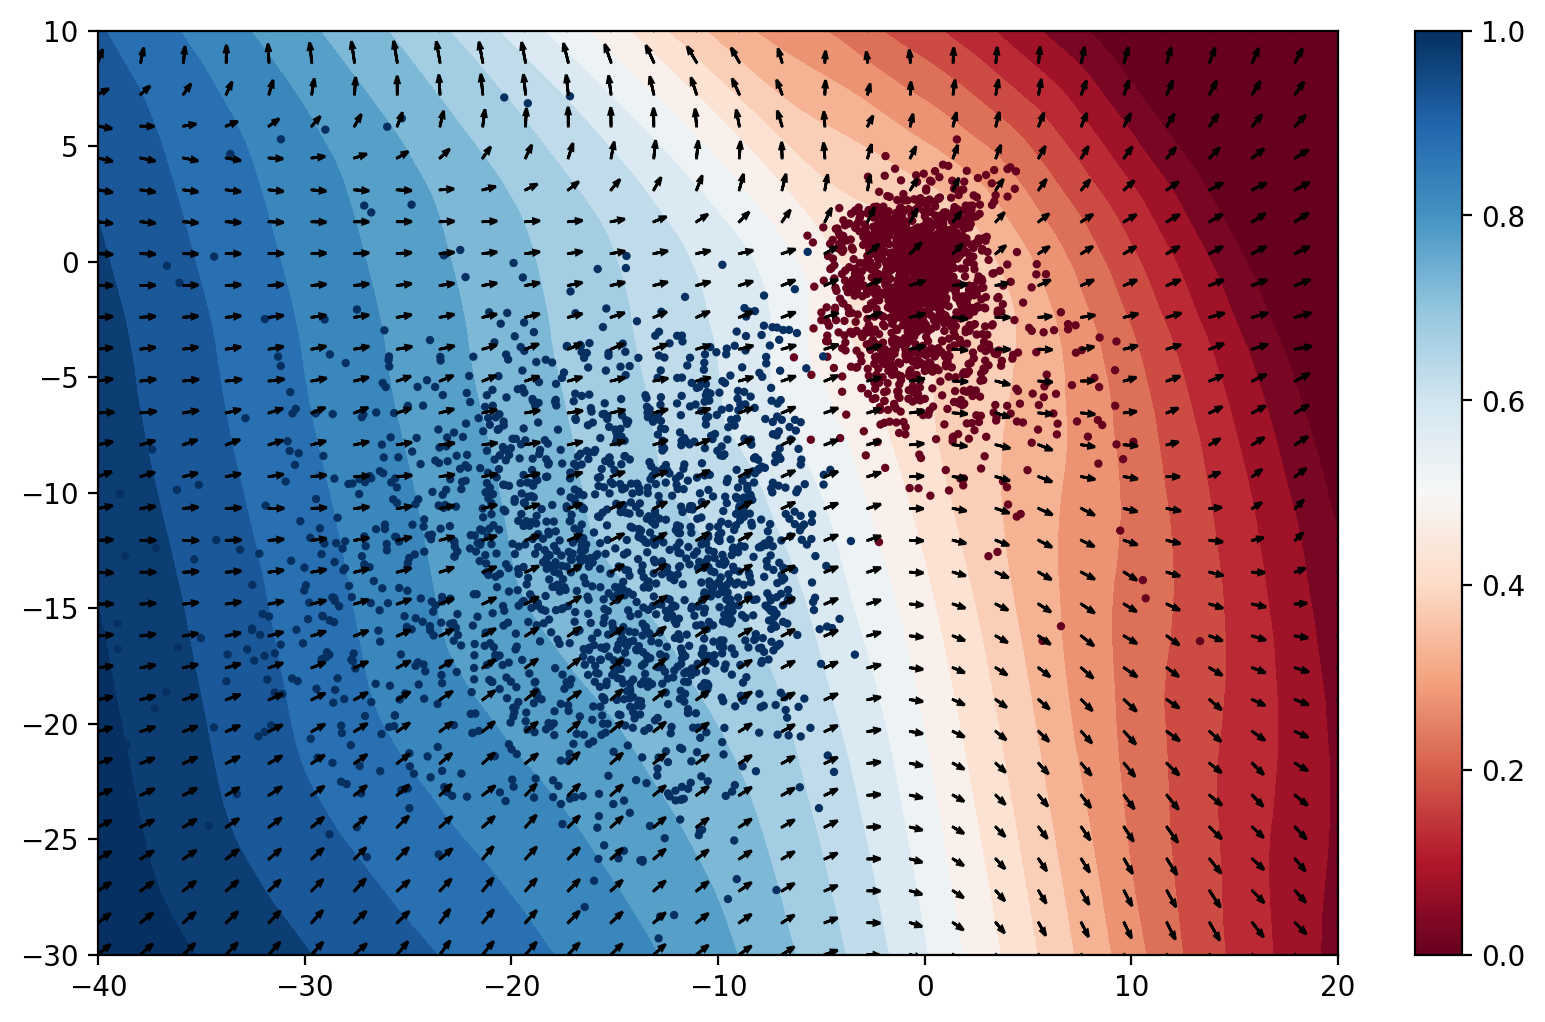

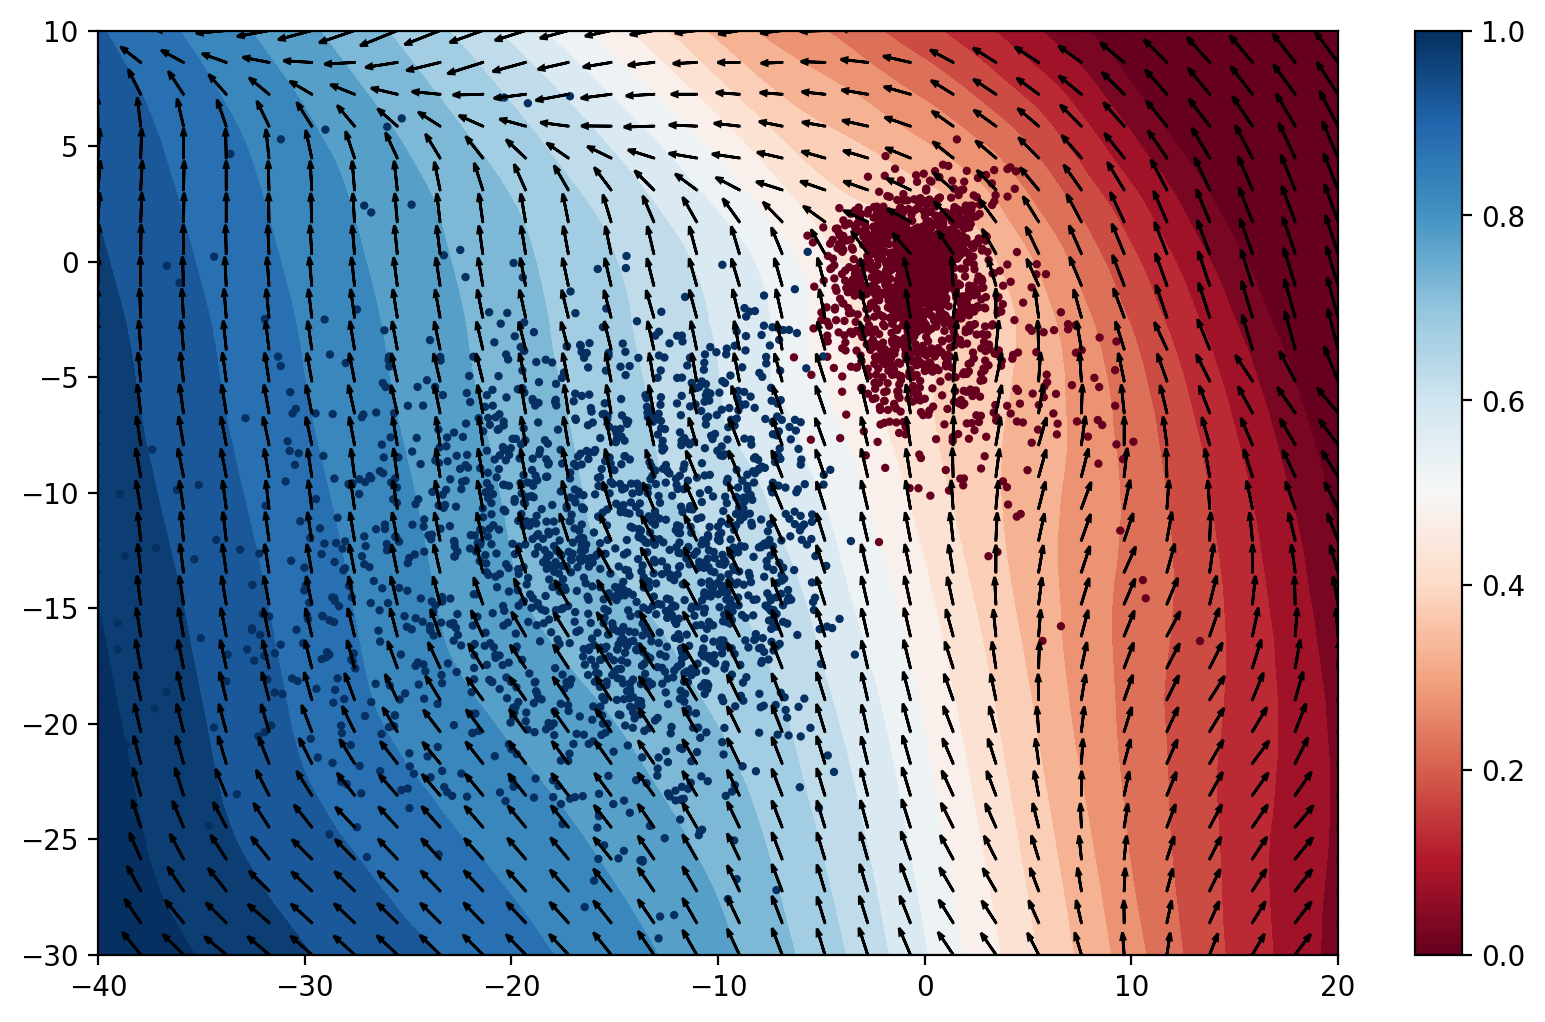

In [67]:
X_vec, Y_vec = np.meshgrid(np.linspace(-40,20,30), np.linspace(-30,10,30))
vec_grid_points = torch.tensor(np.stack([X_vec.flatten(), Y_vec.flatten()]).T).float()

vec_grid = generator2.W_list[0](vec_grid_points).detach().numpy()

plt.figure(figsize=[10,6], dpi=200)
plt.contourf(X, Y, grid_preds.reshape((100,100)), 30, cmap='RdBu', vmin=-40, vmax=40)
plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=4, cmap='RdBu', alpha=1)
plt.axis([-40,20,-30,10])
for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), head_width=.2, color='k')
plt.colorbar()

plt.show()

X_vec, Y_vec = np.meshgrid(np.linspace(-40,20,30), np.linspace(-30,10,30))
vec_grid_points = torch.tensor(np.stack([X_vec.flatten(), Y_vec.flatten()]).T).float()

vec_grid = generator2.W_list[1](vec_grid_points).detach().numpy()

plt.figure(figsize=[10,6], dpi=200)
plt.contourf(X, Y, grid_preds.reshape((100,100)), 30, cmap='RdBu', vmin=-40, vmax=40)
plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=4, cmap='RdBu', alpha=1)
plt.axis([-40,20,-30,10])
for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), head_width=.2, color='k')
plt.colorbar()

plt.show()

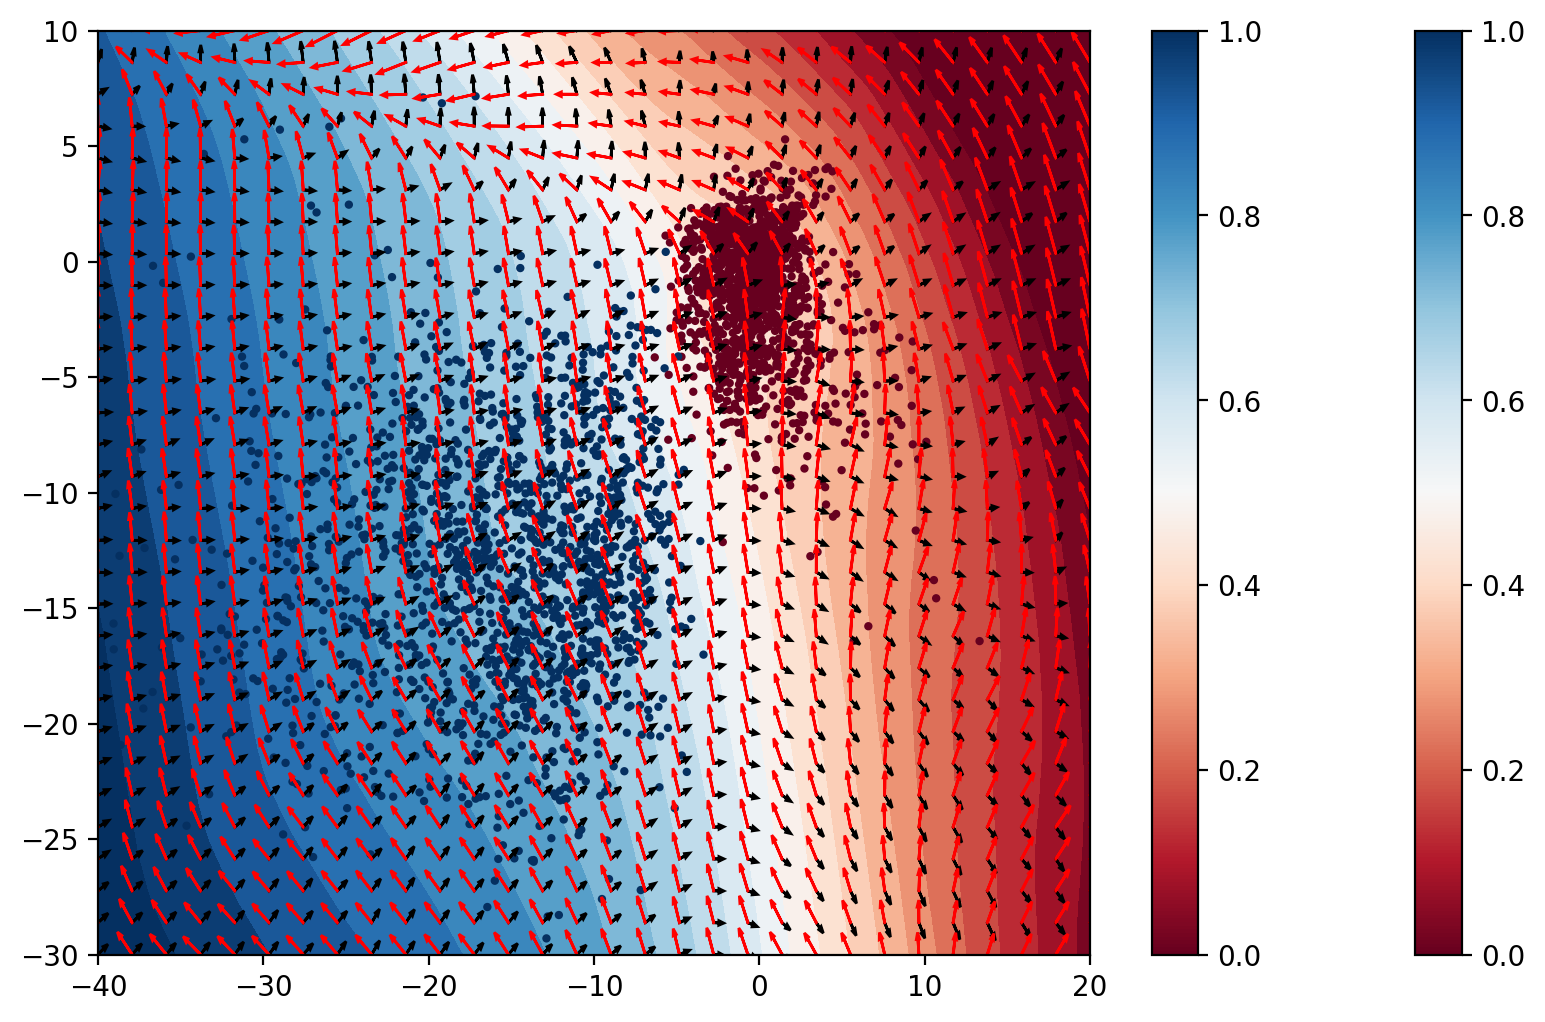

In [68]:
X_vec, Y_vec = np.meshgrid(np.linspace(-40,20,30), np.linspace(-30,10,30))
vec_grid_points = torch.tensor(np.stack([X_vec.flatten(), Y_vec.flatten()]).T).float()

plt.figure(figsize=[10,6], dpi=200)
plt.contourf(X, Y, grid_preds.reshape((100,100)), 30, cmap='RdBu', vmin=-40, vmax=40)
plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=4, cmap='RdBu', alpha=1)
plt.axis([-40,20,-30,10])

vec_grid = generator2.W_list[0](vec_grid_points).detach().numpy()

for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), head_width=.2, color='k')
plt.colorbar()

vec_grid = generator2.W_list[1](vec_grid_points).detach().numpy()

for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), head_width=.2, color='r')
plt.colorbar()

plt.show()

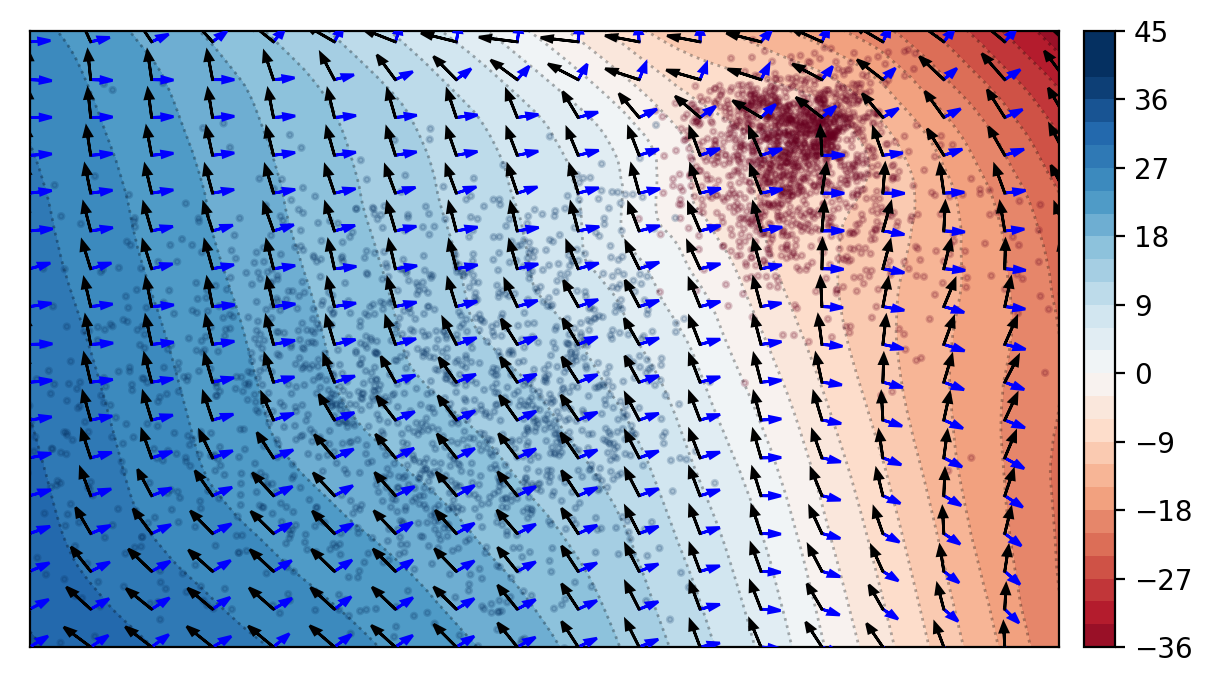

In [69]:
plt.style.use('default')

X_vec, Y_vec = np.meshgrid(np.linspace(-30,15,20), np.linspace(-25,10,20))
vec_grid_points = torch.tensor(np.stack([X_vec.flatten(), Y_vec.flatten()]).T).float()



plt.figure(figsize=[8,4], dpi=200)
plt.contourf(X, Y, np.maximum(-36,grid_preds.reshape((100,100))), 30, cmap='RdBu', vmin=-40, vmax=40, zorder=-20)
plt.colorbar(pad=.02)
plt.contour(X, Y, np.maximum(-36,grid_preds.reshape((100,100))), 30, cmap='gray', vmin=0, vmax=10000, 
            linewidths=1, linestyles='dotted', zorder=-10, alpha=.3)

plt.scatter(*z_test.detach().numpy().T, c=y_test.detach().numpy(), s=4, cmap='RdBu', alpha=.2)
# plt.scatter(*z_test[658].detach().numpy(), c='yellow', s=100, marker='*', cmap='RdBu', alpha=1)
plt.axis([-30,10,-25,5])
plt.xticks([])
plt.yticks([])

vec_grid = generator2.W_list[0](vec_grid_points).detach().numpy()
for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), lw=1, head_width=.3, color='b', zorder=3)
    
vec_grid = generator2.W_list[1](vec_grid_points).detach().numpy()
for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), lw=1, head_width=.3, color='k', zorder=3)
    
plt.savefig('binary_2d_latent_vector_plot_2generators.png', bbox_inches='tight')

In [70]:
loss = ensemble_loss(dataset, 
                         generator2, 
                         h_inv=h_inv,
                         h_norm=h_norm,
                         h_orth=h_orth,
                         h_clos=h_clos,
                         eps=eps, return_components=True)

In [71]:
loss

(0.26803064346313477, 0.40759193897247314, 0.0037874781992286444, 0.0)